In [1]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

# model_name = "deepseek-ai/deepseek-math-7b-instruct"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model.generation_config = GenerationConfig.from_pretrained(model_name)
model.generation_config.pad_token_id = model.generation_config.eos_token_id

NUM_COT = 3

/Users/vivekvajipey/miniconda3/envs/nightly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:22<00:00,  7.40s/it]


In [2]:
import pandas as pd

gpt35_df = pd.read_csv('../conditional/data/112_gsm8k_gpt35_cot_onesent_responses.csv')
gpt35_df.head(3)

,Problem Number,Question,Answer,CoT Response,CoT Sentences,CoT Steps,split,Paraphrased Question,Paraphrased CoT Steps,True Answer,Final Score,CoT Response 2,logprobs,tokens,api_response,One Sentence Response,onesent_logprobs,onesent_tokens,onesent_api_top_logprobs
0,0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,"First, let's find out how many clips Natalia s...","**\nFirst, let's find out how many clips Natal...","[""First, let's find out how many clips Natalia...",train,Derek collected seashells from 48 of his frien...,"['First, we need to figure out the number of s...",72,1,"In April, Natalia sold clips to 48 friends. \n...","[-0.1291976, -0.00031806578, -0.000602715, -0....","['In', ' April', ',', ' Natal', 'ia', ' sold',...",ChatCompletion(id='chatcmpl-91nJqookKzsoRSnZIN...,Natalia sold a total of 72 clips in April and ...,"[-0.0030397435, -3.0545007e-06, -8.657073e-06,...","['N', 'atal', 'ia', ' sold', ' a', ' total', '...","[[('N', -0.0030397435), ('In', -5.8738513), ('..."
1,1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,"To find out how much Weng earned, we need to c...","**\nTo find out how much Weng earned, we need ...","['To find out how much Weng earned, we need to...",train,Liam makes $12 per hour tutoring. He tutored f...,"[""First, we need to figure out Liam's earnings...",10,1,"First, we need to convert the 50 minutes into ...","[-0.35689792, -0.0009994634, -0.37169525, -0.0...","['First', ',', ' we', ' need', ' to', ' conver...",ChatCompletion(id='chatcmpl-91nJtqHb47BwX4XQfg...,Weng earned $10 for 50 minutes of babysitting.,"[-0.020672215, -0.00012916465, -0.0022319749, ...","['W', 'eng', ' earned', ' $', '10', ' for', ' ...","[[('W', -0.020672215), ('She', -4.367806), ('Y..."
2,2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<...","First, let's calculate how much money Betty ha...","**\nFirst, let's calculate how much money Bett...","[""First, let's calculate how much money Betty ...",train,Oliver is collecting stickers for his album wh...,"['First, we need to figure out how many sticke...",5,1,"First, let's calculate how much money Betty ha...","[-0.53395826, -0.0011852304, -0.3187719, -0.00...","['First', ',', ' let', ""'s"", ' calculate', ' h...",ChatCompletion(id='chatcmpl-91nJwxRcorbrtebuXS...,Betty still needs $35 more to buy the wallet.,"[-0.0017678854, -4.723352e-06, -0.6021617, -9....","['Bet', 'ty', ' still', ' needs', ' $', '35', ...","[[('Bet', -0.0017678854), ('After', -6.9818764..."


In [ ]:
# def get_fewshot_examples():
    # This is the 8-shot prompt used in the Wang et al., 2023 Self-Consistency paper
#     return """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
# A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees. The answer is 6.
# Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
# A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.
# Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total? 
# A: Leah had 32 chocolates and Leah's sister had 42. That means there were originally 32 + 42 = 74 chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.
# Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
# A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.
# Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
# A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in total he has 7 + 2 = 9 toys. The answer is 9.
# Q: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
# A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The answer is 29.
# Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
# A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.
# Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
# A: She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in the beginning, so now she has $23 - $15 = $8. The answer is 8.
# """

# def get_prompt_message(question, prompt_strat="zero-shot"):
#     prompt = None
#     if prompt_strat == "few-shot":
#         prompt = get_fewshot_examples() + "Q: " + question + "\nA:"
#     elif prompt_strat == "one-shot":
#        prompt = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?\nA: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees. The answer is 6."""
#        prompt += "\nQ: " + question + "\nA:" 
#     elif prompt_strat == "zero-shot":
#         prompt = f"Q: {question}\nA: Let's think step by step."
#     elif prompt_strat == "zero-shot-deepseek":
#         prompt = question + "\nPlease reason step by step, and put your final answer within \\boxed{}."
#     assert prompt is not None, "Prompting strategy not supported"

#     return [
#         {"role": "user", "content": prompt}
#     ]

In [3]:
def get_fewshot_examples():
    examples = [
        "Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?\nA: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees. The answer is 6",
        "Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?\nA: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.",
        "Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?\nA: Leah had 32 chocolates and Leah's sister had 42. That means there were originally 32 + 42 = 74 chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.",
        "Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?\nA: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.",
        "Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?\nA: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in total he has 7 + 2 = 9 toys. The answer is 9.",
        "Q: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?\nA: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The answer is 29.",
        "Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?\nA: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.",
        "Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?\nA: She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in the beginning, so now she has $23 - $15 = $8. The answer is 8."
    ]
    return examples

In [4]:
def get_prompt_message(question, num_fewshot_examples=1):
    # num_fewshot_examples=-1 for direct prompting, 0 for zero-shot CoT
    examples = get_fewshot_examples()
    prompt = ""
    
    if num_fewshot_examples > 0: 
        for i in range(min(num_fewshot_examples, len(examples))):
            prompt += examples[i] + "\n"
    
    prompt += "Q: " + question + "\nA:"

    if num_fewshot_examples == 0:
        prompt += " Let's think step by step." 
    
    return [
        {"role": "user", "content": prompt}
    ]

In [54]:
ken_q = gpt35_df['Question'].tolist()[7]
prompt_message = get_prompt_message(ken_q, num_fewshot_examples=-1)
print(prompt_message[0]['content'])

Q: Ken created a care package to send to his brother, who was away at boarding school.  Ken placed a box on a scale, and then he poured into the box enough jelly beans to bring the weight to 2 pounds.  Then, he added enough brownies to cause the weight to triple.  Next, he added another 2 pounds of jelly beans.  And finally, he added enough gummy worms to double the weight once again.  What was the final weight of the box of goodies, in pounds?
A:


In [34]:
from pprint import pprint

pprint(tokenizer.apply_chat_template(get_prompt_message(ken_q, 1), add_generation_prompt=True, return_tensors="pt", tokenize=False))

('<s>[INST] Q: There are 15 trees in the grove. Grove workers will plant trees '
 'in the grove today. After they are done, there will be 21 trees. How many '
 'trees did the grove workers plant today?\n'
 'A: We start with 15 trees. Later we have 21 trees. The difference must be '
 'the number of trees they planted. So, they must have planted 21 - 15 = 6 '
 'trees. The answer is 6\n'
 'Q: Ken created a care package to send to his brother, who was away at '
 'boarding school.  Ken placed a box on a scale, and then he poured into the '
 'box enough jelly beans to bring the weight to 2 pounds.  Then, he added '
 'enough brownies to cause the weight to triple.  Next, he added another 2 '
 'pounds of jelly beans.  And finally, he added enough gummy worms to double '
 'the weight once again.  What was the final weight of the box of goodies, in '
 'pounds?\n'
 'A: [/INST]')


In [35]:
ken_answers = []
ken_input = tokenizer.apply_chat_template(get_prompt_message(ken_q, 1), add_generation_prompt=True, return_tensors="pt")
for _ in range(1):
    ken_outputs = model.generate(
        ken_input.to(model.device), 
        max_new_tokens=1000, 
        do_sample=True, 
        # top_k=40, 
        temperature=0.7,
        return_dict_in_generate=True, 
        output_scores=True
    )
    print("Output Shape: ", ken_outputs.sequences.shape)
    print("Output:\n" + 100 * '-')
    pprint(tokenizer.decode(ken_outputs.sequences[0], skip_special_tokens=True))
    ken_answers.append(ken_outputs.sequences)

Output Shape:  torch.Size([1, 351])
Output:
----------------------------------------------------------------------------------------------------
('[INST] Q: There are 15 trees in the grove. Grove workers will plant trees in '
 'the grove today. After they are done, there will be 21 trees. How many trees '
 'did the grove workers plant today?\n'
 'A: We start with 15 trees. Later we have 21 trees. The difference must be '
 'the number of trees they planted. So, they must have planted 21 - 15 = 6 '
 'trees. The answer is 6\n'
 'Q: Ken created a care package to send to his brother, who was away at '
 'boarding school.  Ken placed a box on a scale, and then he poured into the '
 'box enough jelly beans to bring the weight to 2 pounds.  Then, he added '
 'enough brownies to cause the weight to triple.  Next, he added another 2 '
 'pounds of jelly beans.  And finally, he added enough gummy worms to double '
 'the weight once again.  What was the final weight of the box of goodies, in '
 'pou

1. Generate (r_k, a_k) Pairs

In [6]:
import re

def extract_last_sentence(text):
    # Split the text into sentences based on both "." and "\n"
    sentences = re.split(r'[.\n]+', text)
    sentences = [sentence.strip() for sentence in sentences if sentence] # Filter out empty strings and strip whitespace
    return sentences[-1] if sentences else ""

text_example = "This is a sentence. This is another sentence\nThis is the last sentence."
print("Last sentence:", extract_last_sentence(text_example))

Last sentence: This is the last sentence


In [7]:
def generate_rk_ak_pairs(model, tokenizer, question, num_samples=2, num_fewshot=1):
    rk_ak_pairs = []

    prompt_messages = get_prompt_message(question, num_fewshot)
    for _ in range(num_samples):
        # prompt_input = tokenizer.apply_chat_template(get_prompt_message(prompt_messages, prompt_strategy), add_generation_prompt=True, return_tensors="pt").to(model.device)

        prompt_input = tokenizer.apply_chat_template(prompt_messages, add_generation_prompt=True, return_tensors="pt").to(model.device)
        outputs = model.generate(
            prompt_input,
            max_length=10000,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            # top_k=40, 
            temperature=1.0,
            # return_dict_in_generate=True, 
            # output_scores=True
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pprint(generated_text)
        
        # Extract a_k by finding the last sentence
        last_sentence = extract_last_sentence(generated_text)
        rk_ak_pairs.append((generated_text, last_sentence))
    
    return rk_ak_pairs

In [64]:
question = gpt35_df['Question'].tolist()[0]
rk_ak_pairs = generate_rk_ak_pairs(model, tokenizer, question, num_samples=10, num_fewshot=2)

[{'role': 'user', 'content': 'Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?\nA: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees. The answer is 6\nQ: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?\nA: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.\nQ: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\nA:'}]
('[INST] Q: There are 15 trees in the grove. Grove workers will plant trees in '
 'the grove today. After they are done, there will be 21 trees. How many trees '
 'did the grove workers plant today?\n'
 'A: We start with 15 trees. Lat

In [121]:
for i, (rk, ak) in enumerate(rk_ak_pairs):
    print(f"Sample {i+1}:")
    # print("Reasoning Path (r_k):", rk)
    print("Answer (a_k):", ak)
    print("-" * 50)

Sample 1:
Answer (a_k): The answer is 72.
--------------------------------------------------
Sample 2:
Answer (a_k): The answer is 72.
--------------------------------------------------
Sample 3:
Answer (a_k): The answer is 72.
--------------------------------------------------
Sample 4:
Answer (a_k): The answer is 72.
--------------------------------------------------
Sample 5:
Answer (a_k): But, in this question, it's easier to find the direct sum of the clips sold in April and May.
--------------------------------------------------
Sample 6:
Answer (a_k): Answer: 72.
--------------------------------------------------
Sample 7:
Answer (a_k): The answer is 72.
--------------------------------------------------
Sample 8:
Answer (a_k): The answer is 72.
--------------------------------------------------
Sample 9:
Answer (a_k): The answer is 72.
--------------------------------------------------
Sample 10:
Answer (a_k): The answer is 72.
--------------------------------------------------

In [57]:
# No CoT Prompt
question = gpt35_df['Question'].tolist()[0]
rk_ak_pairs = generate_rk_ak_pairs(model, tokenizer, question, num_samples=10, num_fewshot=-1)

[{'role': 'user', 'content': 'Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\nA:'}]
('[INST] Q: Natalia sold clips to 48 of her friends in April, and then she '
 'sold half as many clips in May. How many clips did Natalia sell altogether '
 'in April and May?\n'
 'A: [/INST] To find the total number of clips Natalia sold in April and May, '
 'we need to first find out how many clips she sold in each month, and then '
 'add those two numbers together.\n'
 '\n'
 'In April, Natalia sold clips to 48 friends.\n'
 '\n'
 'In May, she sold half as many clips as in April. Half of 48 is 24. So, in '
 'May, she sold 24 clips.\n'
 '\n'
 'Therefore, the total number of clips Natalia sold in April and May is:\n'
 '\n'
 'Total clips sold = Clips sold in April + Clips sold in May\n'
 'Total clips sold = 48 + 24\n'
 'Total clips sold = 72\n'
 '\n'
 'So, Natalia sold a total of 72 clips in Apr

In [61]:
# NO CoT Prompt
for i, (rk, ak) in enumerate(rk_ak_pairs):
    print(f"Sample {i+1}:")
    # print("Reasoning Path (r_k):", rk)
    print("Answer (a_k):", ak)
    print("-" * 50)

Sample 1:
Answer (a_k): So, Natalia sold a total of 72 clips in April and May
--------------------------------------------------
Sample 2:
Answer (a_k): So, Natalia sold a total of 72 clips in April and May
--------------------------------------------------
Sample 3:
Answer (a_k): Altogether, Natalia sold 48 + 24 = <<48+24=72>>72 clips in April and May
--------------------------------------------------
Sample 4:
Answer (a_k): 48 clips (April) + 24 clips (May) = 72 clips in total
--------------------------------------------------
Sample 5:
Answer (a_k): Therefore, Natalia sold a total of 72 clips in April and May
--------------------------------------------------
Sample 6:
Answer (a_k): Together, Natalia sold 48 + 24 = <box>72</box> clips in April and May
--------------------------------------------------
Sample 7:
Answer (a_k): Together, she sold 48 + 24 = <<48+24=72>>72 clips in April and May
--------------------------------------------------
Sample 8:
Answer (a_k): Altogether, Natali

Step 2: Extract Unique Answers ({A})

In [120]:
import re

def extract_last_integer(ak):
    numbers = re.findall(r'\d+', ak)
    return int(numbers[-1]) if numbers else None

def extract_unique_answers_as_integers(rk_ak_pairs):
    unique_answers = dict()

    for _, ak in rk_ak_pairs:
        # Extract the last integer from the answer
        last_integer = extract_last_integer(ak)
        print(last_integer, " : ", ak)
        assert last_integer is not None, "no ints in a_k"
        unique_answers[last_integer] = 1 + unique_answers.get(last_integer, 0)

    return unique_answers

unique_answers = extract_unique_answers_as_integers(rk_ak_pairs)

print("Unique Numerical Answers (A):")
for answer in unique_answers:
    print(answer)

72  :  The answer is 72.
72  :  The answer is 72.
72  :  The answer is 72.
72  :  The answer is 72.
None  :  But, in this question, it's easier to find the direct sum of the clips sold in April and May.


AssertionError: no ints in a_k

Step 3: Calculate -log(a_i | q) for each unique answer

In [118]:
def to_tokens_and_logprobs(model, tokenizer, input_texts):
    input_ids = tokenizer(input_texts, padding=True, return_tensors="pt").input_ids.to(model.device)
    # print("input_ids: ", input_ids.shape)
    outputs = model(input_ids)
    probs = torch.log_softmax(outputs.logits, dim=-1).detach()

    # collect the probability of the generated token -- probability at index 0 corresponds to the token at index 1
    probs = probs[:, :-1, :]
    input_ids = input_ids[:, 1:]
    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze(-1)

    batch = []
    for input_sentence, input_probs in zip(input_ids, gen_probs):
        text_sequence = []
        for token, p in zip(input_sentence, input_probs):
            if token not in tokenizer.all_special_ids:
                text_sequence.append((tokenizer.decode(token), p.item()))
        batch.append(text_sequence)
    return batch



In [66]:
# Example input texts
input_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "GPT-4 is an iteration of OpenAI's language models."
]

# Get tokens and log probabilities
token_logprobs = to_tokens_and_logprobs(model, tokenizer, input_texts)

# Print the results
for i, text_sequence in enumerate(token_logprobs, start=1):
    print(f"Input {i}:")
    for token, log_prob in text_sequence:
        print(f"Token: {token}, Log Probability: {log_prob}")
    print("-" * 30)

input_ids:  torch.Size([2, 16])
Input 1:
Token: The, Log Probability: -7.714340686798096
Token: quick, Log Probability: -8.608076095581055
Token: brown, Log Probability: -4.366868019104004
Token: f, Log Probability: -0.035067249089479446
Token: ox, Log Probability: -0.00020358874462544918
Token: j, Log Probability: -0.14347299933433533
Token: umps, Log Probability: -0.000950004265177995
Token: over, Log Probability: -0.007832174189388752
Token: the, Log Probability: -0.23375436663627625
Token: lazy, Log Probability: -0.014055783860385418
Token: dog, Log Probability: -0.01041194424033165
Token: ., Log Probability: -0.5743593573570251
------------------------------
Input 2:
Token: G, Log Probability: -9.629661560058594
Token: PT, Log Probability: -8.862997055053711
Token: -, Log Probability: -0.27548760175704956
Token: 4, Log Probability: -2.283374309539795
Token: is, Log Probability: -0.4238201081752777
Token: an, Log Probability: -2.23352313041687
Token: iteration, Log Probability: -9.

In [102]:
rk_example = '[INST] Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\nA: [/INST] In April, Natalia sold clips to 48 friends. In May, she sold half as many clips as in April, so she sold 48 * 0.5 = <<48*0.5=24>>24 clips. Altogether, she sold 48 + 24 = <<48+24=72>>72 clips in April and May.'
ai_numeric_example = "72"

input_text = f"{rk_example} The answer is {ai_numeric_example}."
print("Input Text:", input_text)

Input Text: [INST] Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
A: [/INST] In April, Natalia sold clips to 48 friends. In May, she sold half as many clips as in April, so she sold 48 * 0.5 = <<48*0.5=24>>24 clips. Altogether, she sold 48 + 24 = <<48+24=72>>72 clips in April and May. The answer is 72.


In [99]:
[tokenizer.decode(tok) for tok in tokenizer.encode("72.")]

['<s>', '', '7', '2', '.']

In [100]:
token_logprobs_example = to_tokens_and_logprobs(model, tokenizer, [input_text])[0]  # Assuming single input

ai_statement_len = len(tokenizer.encode("72.")) - 2 # -2 to account for '<s>', ''

# Print the tokens and log probabilities
for token, log_prob in token_logprobs_example[-ai_statement_len:]:
    print(f"Token: {token}, Log Probability: {log_prob}")

input_ids:  torch.Size([1, 149])
Token: 7, Log Probability: -8.940656698541716e-06
Token: 2, Log Probability: 0.0
Token: ., Log Probability: -2.2383382320404053


In [103]:
answer_log_probs = sum(log_prob for token, log_prob in token_logprobs_example[-ai_statement_len:] if token in ai_numeric_example)
answer_log_probs_loop = 0.0
for token, log_prob in token_logprobs_example[-ai_statement_len:]:
    if token in ai_numeric_example:
        print(token, log_prob)
        answer_log_probs_loop += log_prob

print("Sum of Log Probabilities for Answer Tokens:", answer_log_probs)
print("Sum of Log Probabilities for Answer Tokens (loop):", answer_log_probs_loop)

7 -8.940656698541716e-06
2 0.0
Sum of Log Probabilities for Answer Tokens: -8.940656698541716e-06
Sum of Log Probabilities for Answer Tokens (loop): -8.940656698541716e-06


In [113]:
pprint(rk_ak_pairs[4][0])

('[INST] Q: There are 15 trees in the grove. Grove workers will plant trees in '
 'the grove today. After they are done, there will be 21 trees. How many trees '
 'did the grove workers plant today?\n'
 'A: We start with 15 trees. Later we have 21 trees. The difference must be '
 'the number of trees they planted. So, they must have planted 21 - 15 = 6 '
 'trees. The answer is 6\n'
 'Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many '
 'cars are in the parking lot?\n'
 'A: There are 3 cars in the parking lot already. 2 more arrive. Now there are '
 '3 + 2 = 5 cars. The answer is 5.\n'
 'Q: Natalia sold clips to 48 of her friends in April, and then she sold half '
 'as many clips in May. How many clips did Natalia sell altogether in April '
 'and May?\n'
 'A: [/INST] In April, Natalia sold clips to 48 friends. In May, she sold half '
 'as many as she did in April, so she sold 48 / 2 = 24 clips. In total, she '
 'sold 48 (April) + 24 (May) = 72 clips.\n'
 '\n'
 '

In [119]:
def calculate_logp_ai_given_q_with_logprobs(model, tokenizer, rk_ak_pairs, unique_answers):
    logp_ai_given_q = {}

    for ai_numeric in unique_answers:
        total_log_prob = 0.0
        count = 0

        for rk, ak in rk_ak_pairs:
            # print(rk)
            ai_statement = f" The answer is {ai_numeric}."
            ai_num_tokens = len(tokenizer.encode(f"{ai_numeric}."))
            input_text = rk + ai_statement

            token_logprobs = to_tokens_and_logprobs(model, tokenizer, [input_text])[0]  # Assuming single input

            # Sum the log probabilities of the answer tokens
            answer_log_probs = sum(log_prob for token, log_prob in token_logprobs[-ai_num_tokens:] if token in str(ai_numeric))
            print(f"log P(a_i = {ai} | r_k = '{rk[7:10]}...', q) = ", answer_log_probs) 
            print("Original answer for trace (a_k): ", ak)
            print()
            
            total_log_prob += answer_log_probs
            count += 1

        # Calculate the average log probability for ai
        avg_log_prob = total_log_prob / count if count > 0 else float('inf')
        logp_ai_given_q[ai] = -avg_log_prob  # Note the negation to get -log p(a_i | q)

    return logp_ai_given_q

logp_ai_given_q = calculate_logp_ai_given_q_with_logprobs(model, tokenizer, rk_ak_pairs, unique_answers)

for ai, logp in logp_ai_given_q.items():
    print(f"-log p({ai} | q): {logp}")

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.04640601561004587
Original answer for trace (a_k):  The answer is 72.

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.03529231079664896
Original answer for trace (a_k):  The answer is 72.

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.01946594502442167
Original answer for trace (a_k):  The answer is 72.

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.02289163303066033
Original answer for trace (a_k):  The answer is 72.

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.7746880645718193
Original answer for trace (a_k):  But, in this question, it's easier to find the direct sum of the clips sold in April and May.

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.002441805152557208
Original answer for trace (a_k):  Answer: 72.

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.028802971974073444
Original answer for trace (a_k):  The answer is 72.

log P(a_i = 72 | r_k = 'Q: ...', q) =  -0.0523499240844032
Original answer for trace (a_k):  The answer is 72.

log P(a_i = 72 | r_k = 'Q:

Testing Different Questions

In [5]:
for idx, row in gpt35_df[:5].iterrows():
    question = row['Question']
    print("CURRENT QUESTION: ", question)
    rk_ak_pairs = generate_rk_ak_pairs(model, tokenizer, question, num_samples=10, num_fewshot=2)
    unique_answers = extract_unique_answers_as_integers(rk_ak_pairs)
    logp_ai_given_q = calculate_logp_ai_given_q_with_logprobs(model, tokenizer, rk_ak_pairs, unique_answers)

    for ai, logp in logp_ai_given_q.items():
        print(f"-log p({ai} | q): {logp}")

CURRENT QUESTION:  Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?


NameError: name 'generate_rk_ak_pairs' is not defined

Generate logprobs vs output softmax

In [1]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

# model_name = "deepseek-ai/deepseek-math-7b-instruct"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model.generation_config = GenerationConfig.from_pretrained(model_name)
model.generation_config.pad_token_id = model.generation_config.eos_token_id

NUM_COT = 3

/Users/vivekvajipey/miniconda3/envs/nightly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:21<00:00,  7.21s/it]


In [5]:
input_text = "Your input text goes here."

# Tokenize the input text
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)

# Generate the log probabilities
with torch.no_grad():
    output = model.generate(input_ids, output_scores=True, return_dict_in_generate=True)

# Extract the log probabilities
log_probs = output.scores

# Print the log probabilities and probabilities for each token
for i, (token_id, log_prob) in enumerate(zip(input_ids[0], log_probs)):
    token = tokenizer.decode(token_id)
    log_prob_value = log_prob[0, token_id].item()
    prob_value = torch.exp(log_prob[0, token_id]).item()
    print(f"Token: {token} || Log Probability: {log_prob_value:.4f} || Probability: {prob_value:.4f}")

/Users/vivekvajipey/miniconda3/envs/nightly/lib/python3.11/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Token: <s>, Log Probability: -9.3125, Probability: 0.0001
Token: Your, Log Probability: 2.2812, Probability: 9.7889
Token: input, Log Probability: -3.4844, Probability: 0.0307
Token: text, Log Probability: 1.2500, Probability: 3.4903
Token: goes, Log Probability: -3.1406, Probability: 0.0433
Token: here, Log Probability: -0.7227, Probability: 0.4855
Token: ., Log Probability: 3.8750, Probability: 48.1827


In [16]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_logprobs(log_probs, title):
    # Convert log probabilities to probabilities
    probs = torch.exp(log_probs)

    # Get the top 10 tokens with the highest probabilities
    top_probs, top_indices = torch.topk(probs, k=10)

    # Decode the top tokens
    top_tokens = [tokenizer.decode(idx.item()) for idx in top_indices.flatten()]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(top_tokens, top_probs.flatten().tolist())
    plt.xlabel("Tokens")
    plt.ylabel("Probability")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)

# Generate method
temperature = 4.0
with torch.no_grad():
    output = model.generate(
        input_ids,
        output_scores=True,
        return_dict_in_generate=True,
        temperature=temperature
    )
    generate_log_probs = output.scores[-5]  # Get the log probabilities of a specific token

# Forward method
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits
    forward_log_probs = F.log_softmax(logits, dim=-1)
    forward_log_probs = forward_log_probs[0, -5, :]

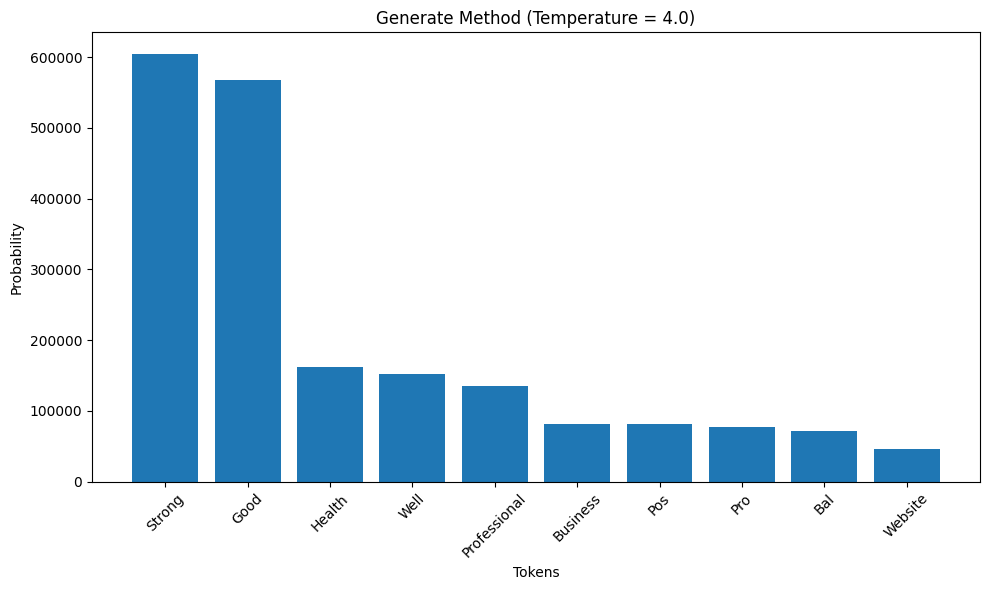

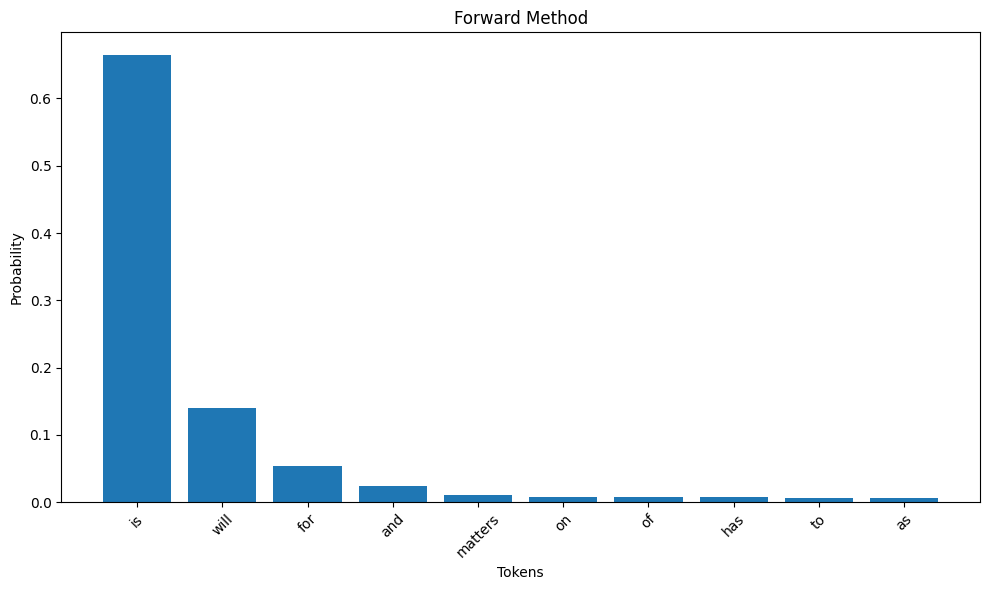

In [24]:
visualize_logprobs(generate_log_probs, f"Generate Method (Temperature = {temperature})")
visualize_logprobs(forward_log_probs, "Forward Method")

Input Tokens:
['<s>', 'Your', 'input', 'text', 'goes', 'here', '.']


/Users/vivekvajipey/miniconda3/envs/nightly/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/vivekvajipey/miniconda3/envs/nightly/lib/python3.11/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



Generate Method:
Number of Log Probabilities: 13
Token Position: 0


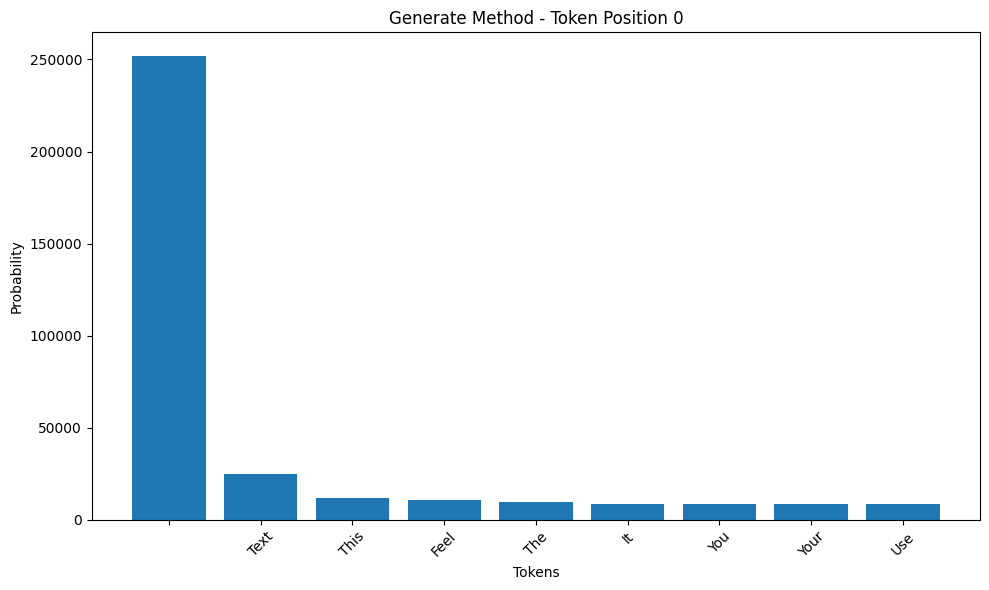

Token Position: 1


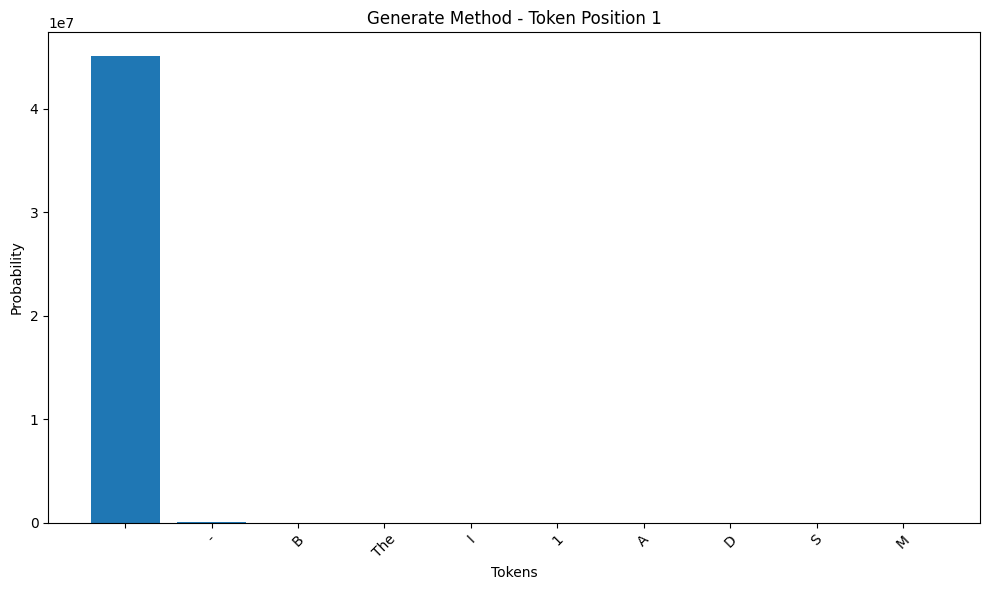

Token Position: 2


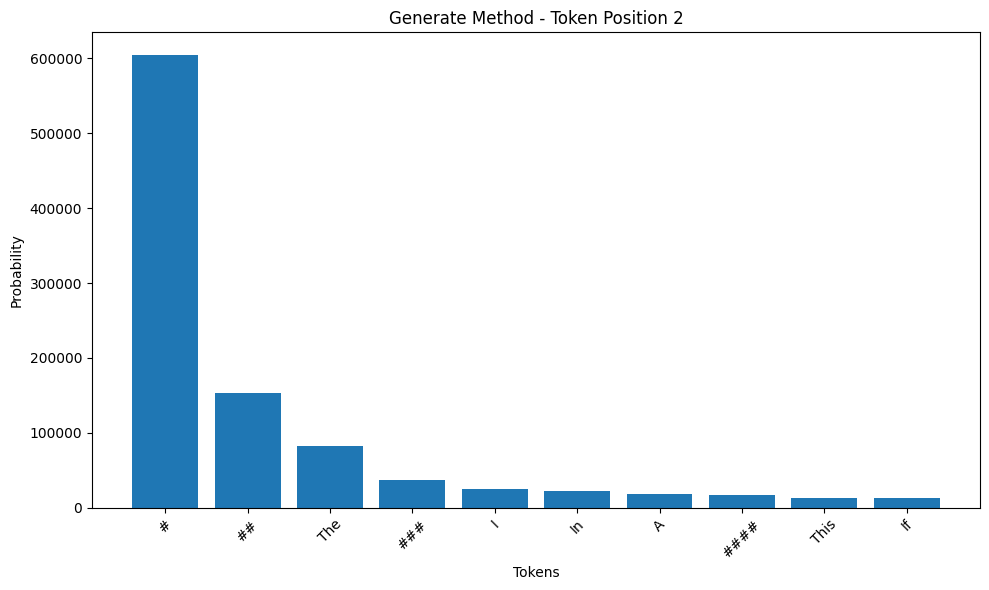

Token Position: 3


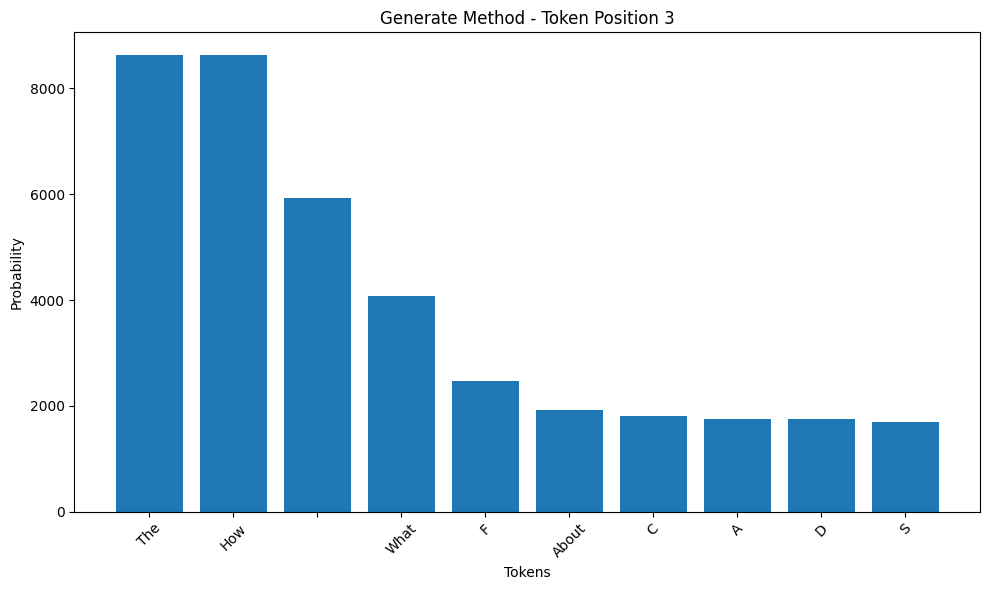

Token Position: 4


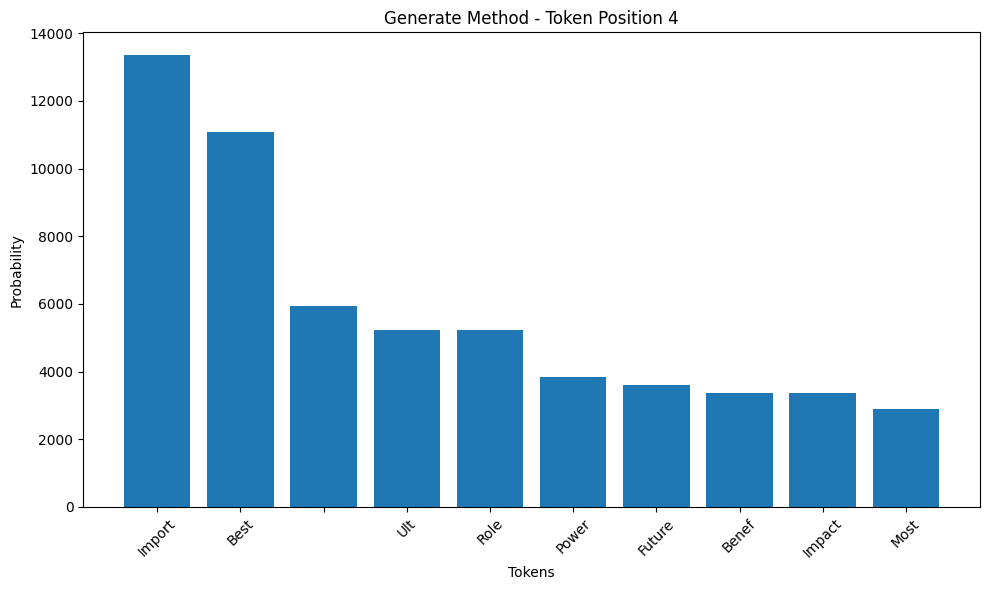

Token Position: 5


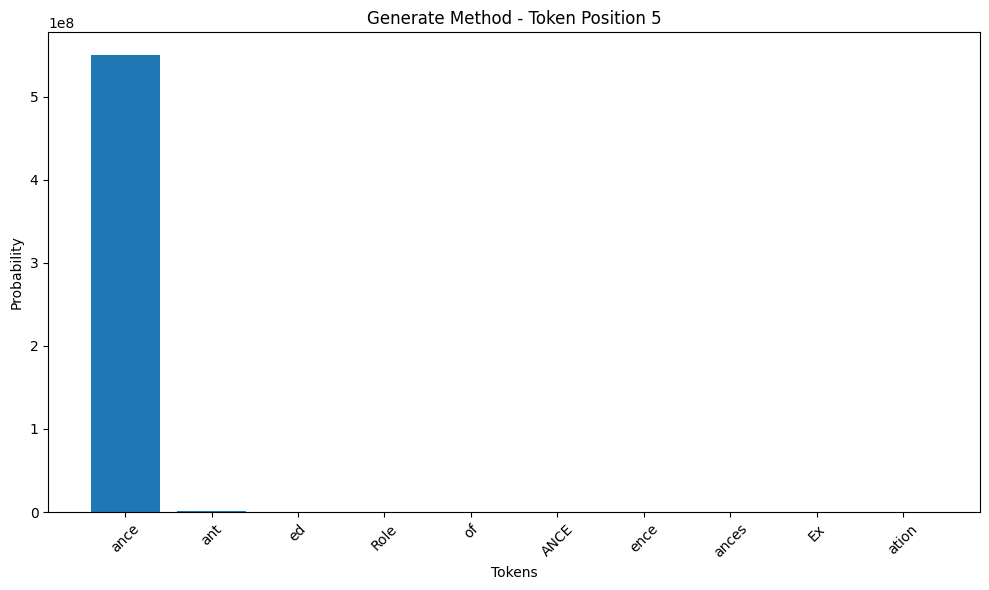

Token Position: 6


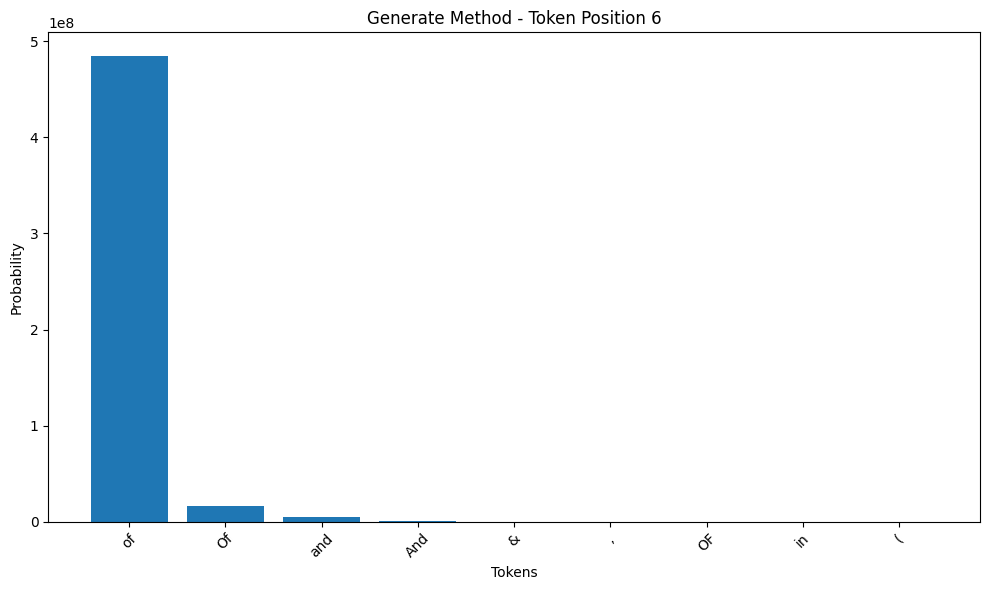

Token Position: 7


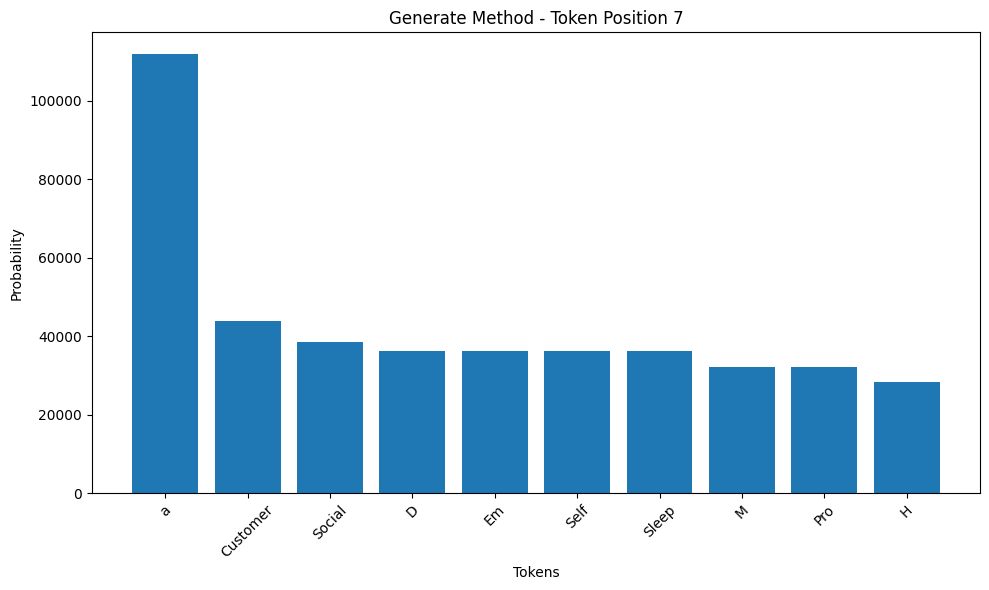

Token Position: 8


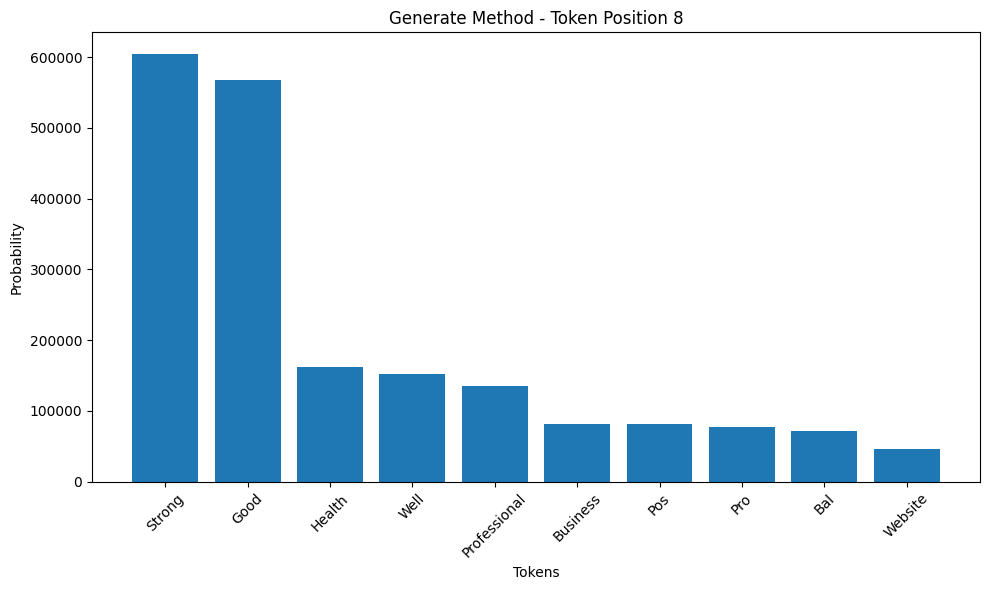

Token Position: 9


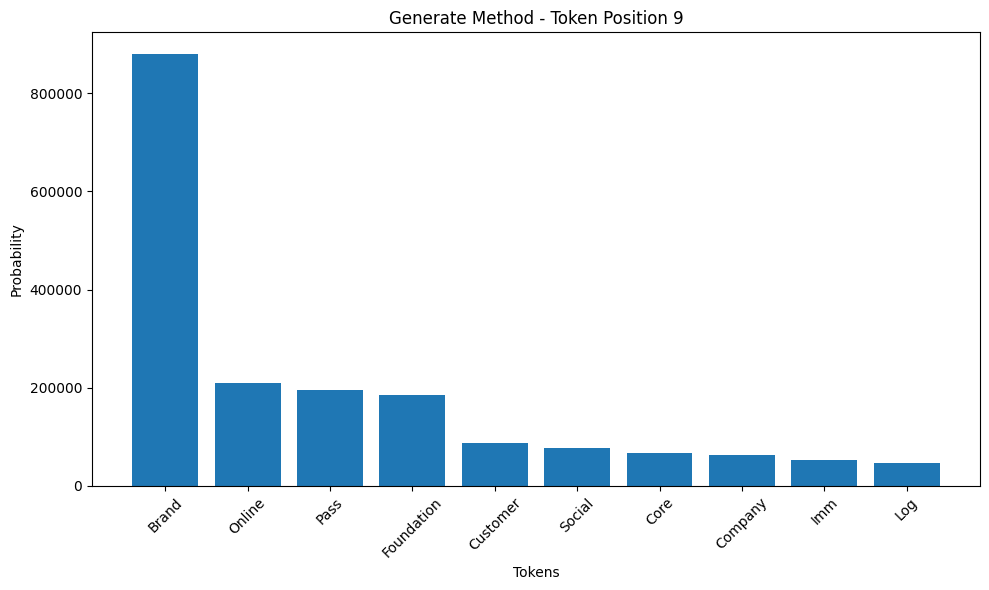

Token Position: 10


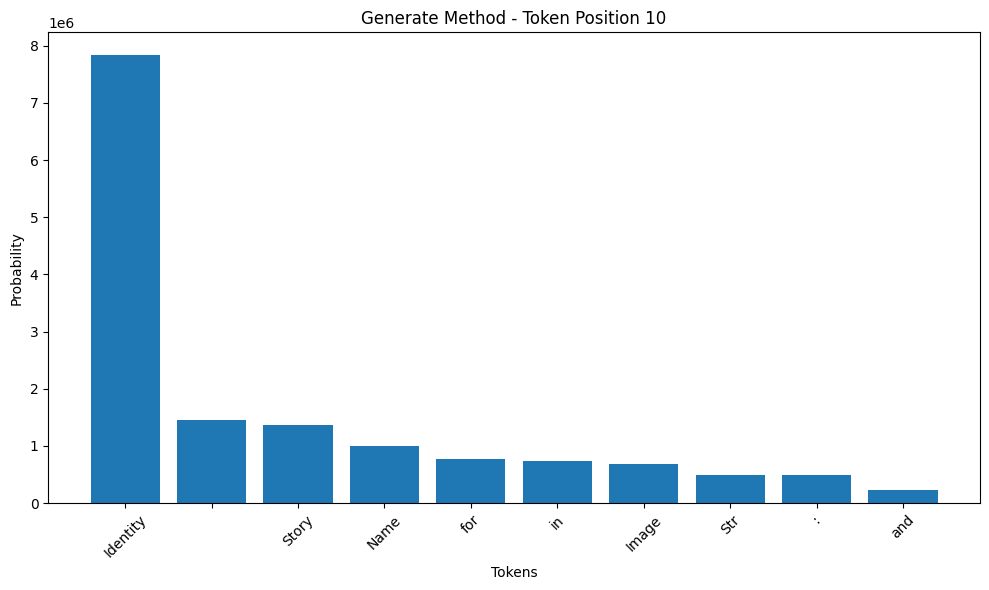

Token Position: 11


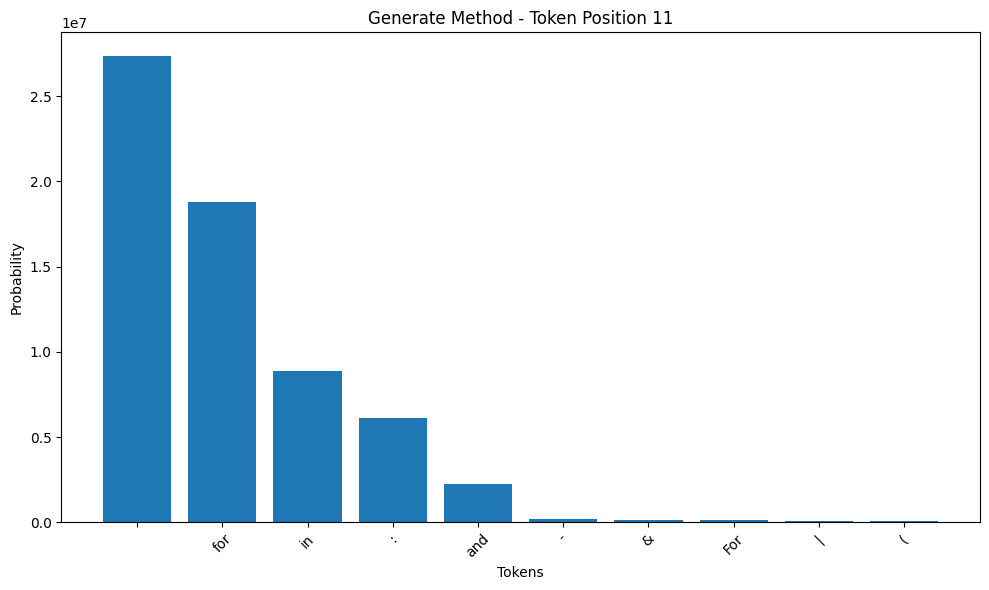

Token Position: 12


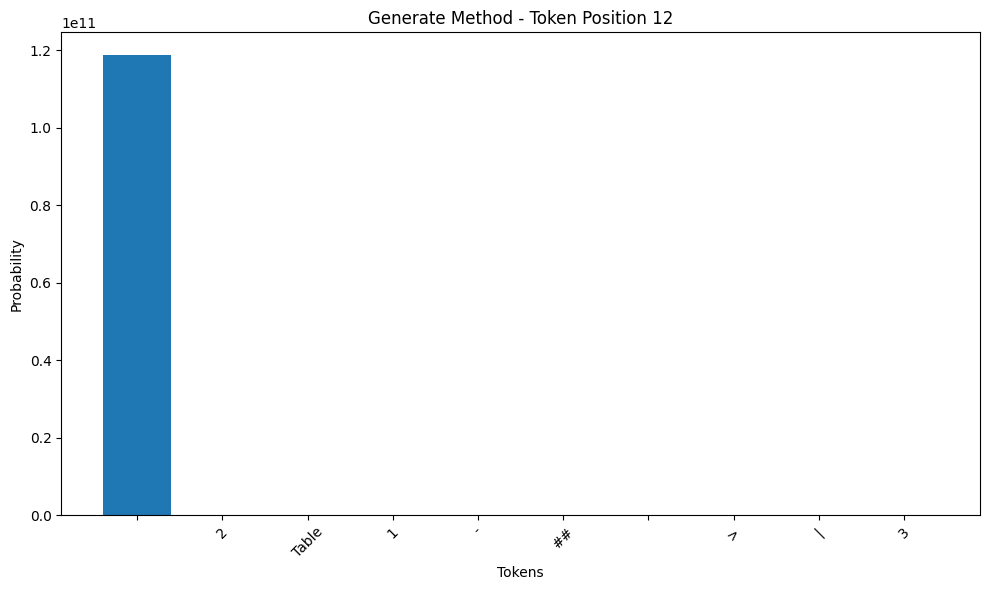


Forward Method:
Number of Log Probabilities: 7
Token Position: 0


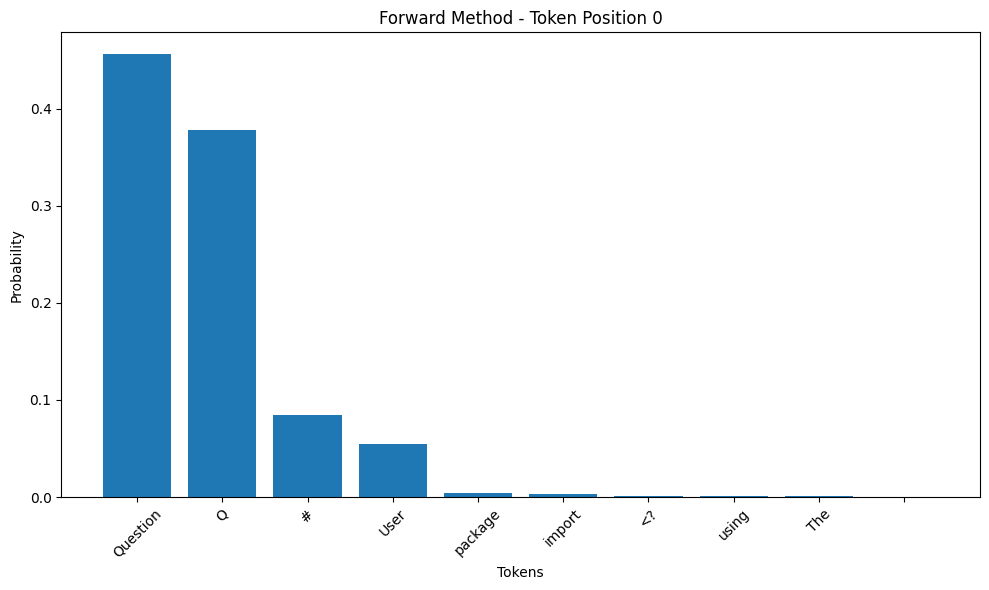

Token Position: 1


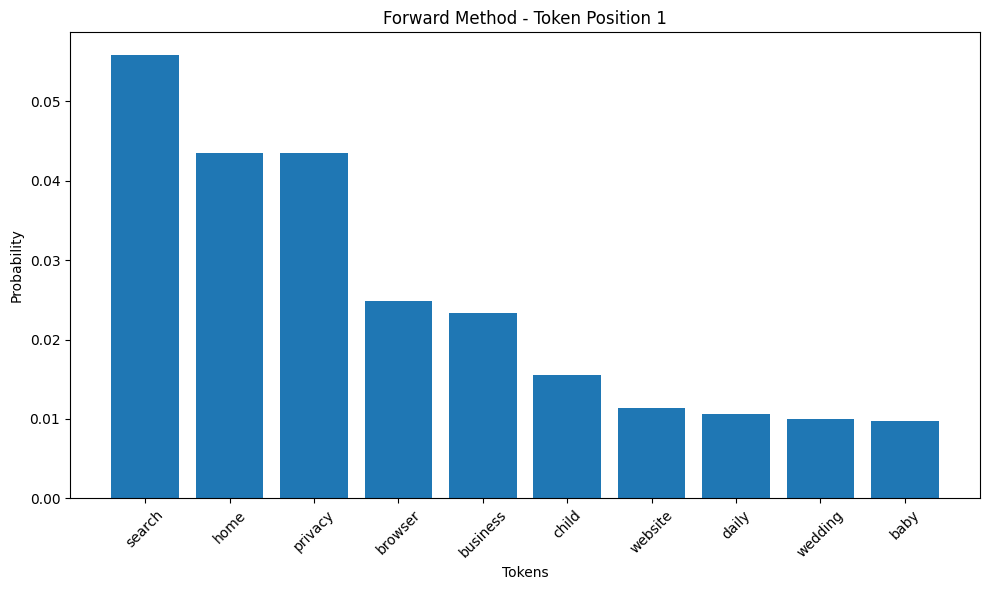

Token Position: 2


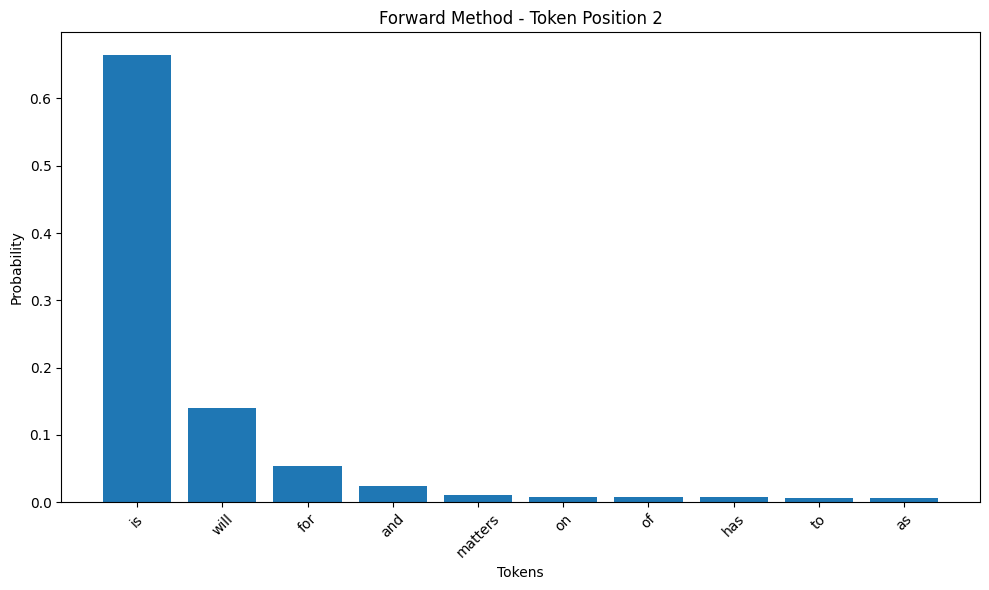

Token Position: 3


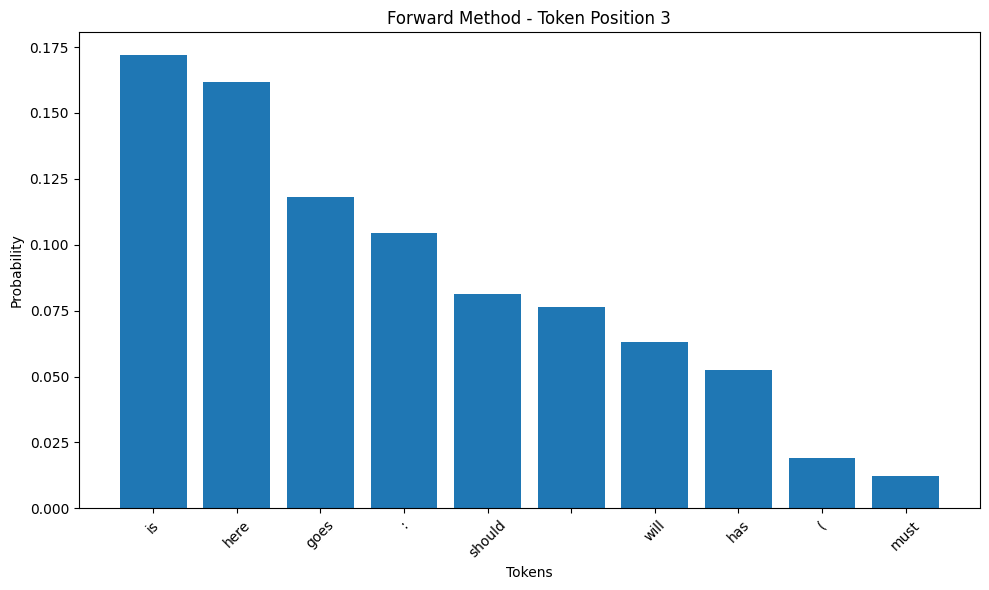

Token Position: 4


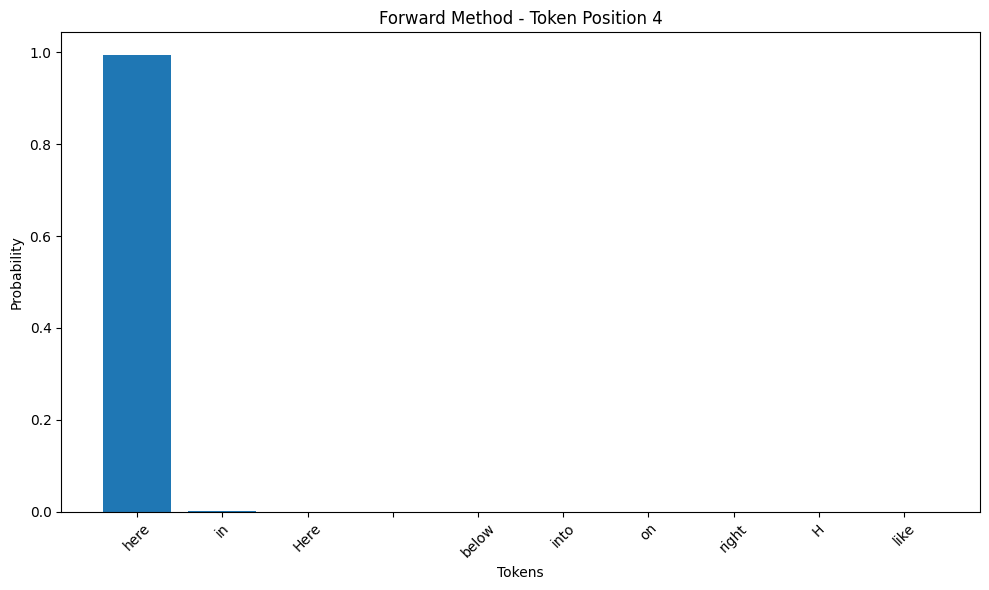

Token Position: 5


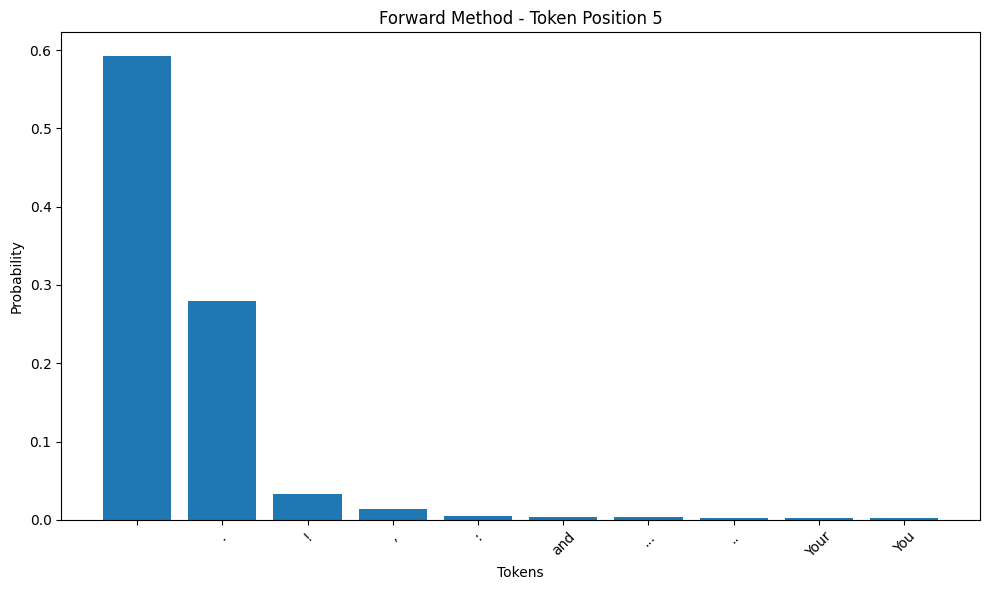

Token Position: 6


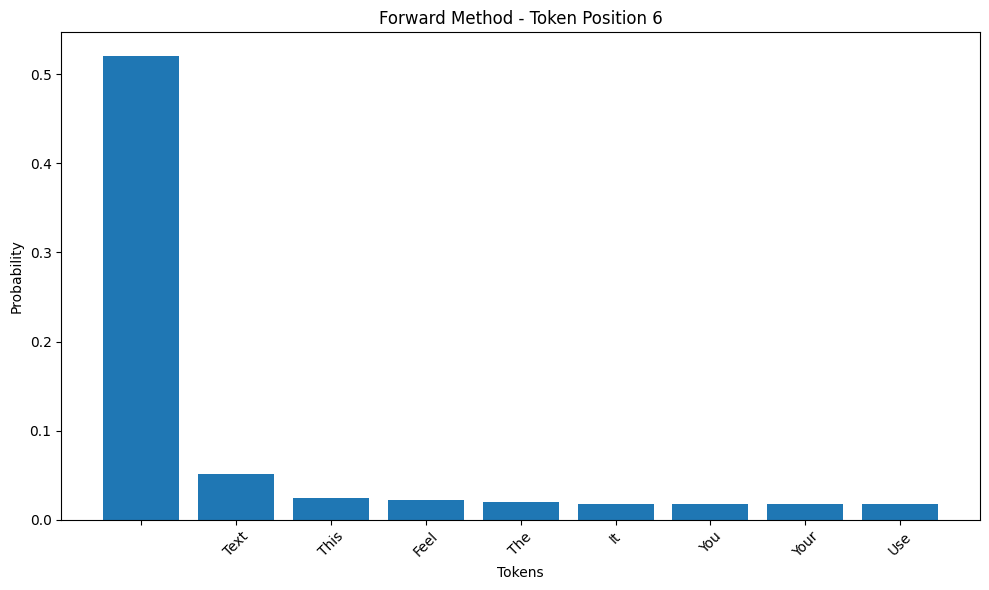

In [26]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_logprobs(log_probs, tokenizer, title):
    # Convert log probabilities to probabilities
    probs = torch.exp(log_probs)

    # Get the top 10 tokens with the highest probabilities
    top_probs, top_indices = torch.topk(probs, k=10)

    # Decode the top tokens
    top_tokens = [tokenizer.decode(idx.item()) for idx in top_indices.flatten()]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(top_tokens, top_probs.flatten().tolist())
    plt.xlabel("Tokens")
    plt.ylabel("Probability")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

input_text = "Your input text goes here."

# Tokenize the input text
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)
input_tokens = [tokenizer.decode(idx) for idx in input_ids[0]]

print("Input Tokens:")
print(input_tokens)

# Generate method
temperature = 0.0
with torch.no_grad():
    output = model.generate(
        input_ids,
        output_scores=True,
        return_dict_in_generate=True,
        temperature=temperature
    )
    generate_log_probs = output.scores

print("\nGenerate Method:")
print(f"Number of Log Probabilities: {len(generate_log_probs)}")
for i, log_probs in enumerate(generate_log_probs):
    print(f"Token Position: {i}")
    visualize_logprobs(log_probs, tokenizer, f"Generate Method - Token Position {i}")

# Forward method
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits
    forward_log_probs = F.log_softmax(logits, dim=-1)

print("\nForward Method:")
print(f"Number of Log Probabilities: {forward_log_probs.shape[1]}")
for i in range(forward_log_probs.shape[1]):
    print(f"Token Position: {i}")
    visualize_logprobs(forward_log_probs[0, i, :], tokenizer, f"Forward Method - Token Position {i}")